In [1]:
%load_ext autoreload
%autoreload 2

from cellmates.data.breast import BreastCancerTissueDataset, get_datasets
from cellmates.data.dataset import collate_fn
from cellmates.model.LightningCellMates import LightningCellMates
from cellmates.model.transformer import CellMatesTransformer
from cellmates.utils import MAX_EFFECTIVE_DISTANCE

from tdm.cell_types import FIBROBLAST, MACROPHAGE, CELL_TYPE_TO_FULL_NAME
from tdm.tissue.raza_breast import RazaBreast
from tdm.tissue.base import Tissue
from tdm.utils import microns

from copy import deepcopy

import torch
from torch.utils.data import DataLoader

import pytorch_lightning as pl

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# from cellmates.style import set_style
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter

# set_style()

In [4]:
from cellmates.utils import PROJECT_ROOT_PATH
PROJECT_ROOT_PATH

experiment_name = 'bla'
n_splits=10

'/home/jsomer/cellmates/kfold_cv/bla_10-fold_losses.csv'

In [3]:
def float_to_percentage_axis(ax, axis='y'):
    
    def to_percentage(x, pos):
        sign_str = '+' if x>0 else ''
        return f'{sign_str}{100 * x :.0f}%'

    if axis == 'y':
        # Setting the formatter for the y-axis
        ax.yaxis.set_major_formatter(FuncFormatter(to_percentage))
    elif axis == 'x':
        ax.xaxis.set_major_formatter(FuncFormatter(to_percentage))

# Cellmates captures the decreasing proliferation rate of fibroblasts as density approaches carrying capacity

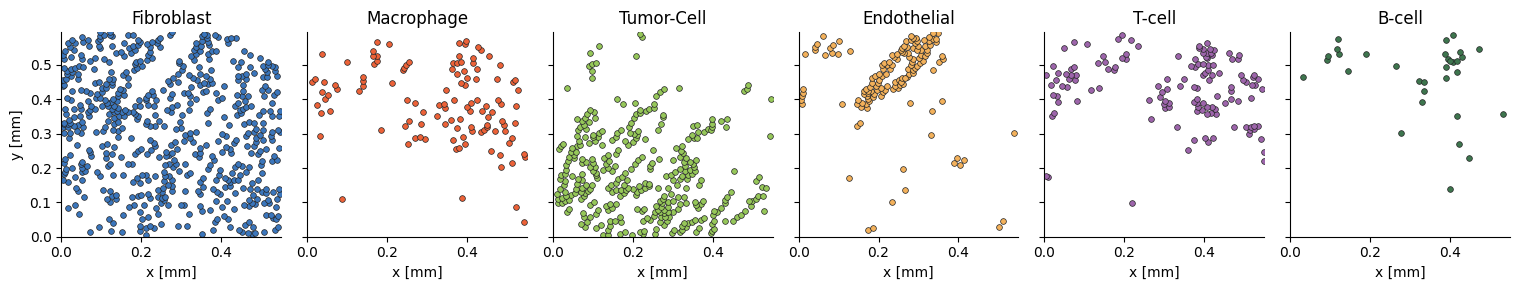

In [4]:
ds = BreastCancerTissueDataset(
    tissue=10, 
    effective_distance=MAX_EFFECTIVE_DISTANCE, 
    responder_cell_type='F'
)

ds.tissue.plot(all_on_one_plot=False, cell_subset=['F', 'M', 'T', 'Tu', 'En', 'B'], plot_effective_capture_area=False, neighborhood_size=140)

In [5]:
model = LightningCellMates.load_from_checkpoint("../checkpoints/cellmates-best_params_10fold_cv_fold_0-epoch=15-val_loss=0.07.ckpt")
model.eval()

LightningCellMates(
  (model): CellMatesTransformer(
    (cell_type_embedding): Embedding(7, 512)
    (distance_embeddings): ModuleDict(
      (Kqk): Embedding(16, 16)
      (Kqr): Embedding(16, 16)
      (Kkr): Embedding(16, 16)
      (Vqk): Embedding(16, 16)
      (Vqr): Embedding(16, 16)
      (Vkr): Embedding(16, 16)
    )
    (encoder_layers): ModuleList(
      (0-3): 4 x CellMatesEncoderLayer(
        (attn): SpatialMultiHeadAttention(
          (Wq): Linear(in_features=512, out_features=512, bias=True)
          (Wk): Linear(in_features=512, out_features=512, bias=True)
          (Wv): Linear(in_features=512, out_features=512, bias=True)
          (Wo): Linear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=1024, bias=True)
        (dropout): Dropout(p=0.28330882325349427, inplace=False)
        (linear2): Linear(in_features=1024, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=0.0002947682439783

In [6]:
original_tissue = RazaBreast(10)
cell_a = 'F'
cell_b = 'Tu'
remove_fraction = 0.1

In [7]:
def sub_sample_tissue(
        tissue: Tissue, 
        cell_b: str, 
        remove_fraction: float,
        lt_x: float = np.inf,
        gt_x: float = -np.inf,
        lt_y: float = np.inf,
        gt_y: float = -np.inf,
    ):


    # sub-sample the cell dataframe:
    df = tissue.cell_df().copy()
    mask = (df.cell_type == cell_b)
    mask = mask & ((df.x > gt_x) & (df.x < lt_x))
    mask = mask & (df.y > gt_y) & (df.y < lt_y)

    # compute number of cells b to remove:
    n_b = mask.sum() # sample from cell subset 
    n_b_to_remove = int(n_b * remove_fraction)

    drop_idxs = df[mask].sample(n_b_to_remove).index
    df = df.drop(drop_idxs)

    # construct new tissue based on sub-sampled cell dataframe:
    return Tissue(
        cell_df=df, 
        tissue_dimensions=tissue.tissue_dimensions(),
        cell_types=tissue.cell_types()
    )

In [8]:
if False:
    sub_sample_tissue(original_tissue, 'F', remove_fraction=1., lt_x=250*1e-6).plot()
    sub_sample_tissue(original_tissue, 'F', remove_fraction=1., lt_x=250*1e-6, lt_y=250*1e-6).plot()
    sub_sample_tissue(original_tissue, 'F', remove_fraction=1., lt_y=250*1e-6).plot()

In [9]:
def predict_all_cells(tissue, model, cell_type):
    # init a dataset and dataloader:
    ds = BreastCancerTissueDataset(
        tissue, 
        effective_distance=MAX_EFFECTIVE_DISTANCE, 
        responder_cell_type=cell_type
    )
    dl = DataLoader(ds, batch_size=8, collate_fn=collate_fn, shuffle=False)

    # compute predictions:
    trainer = pl.Trainer(devices=[4])
    predictions = trainer.predict(model, dl)

    # hack, effectively verbose=False
    from IPython.display import clear_output
    clear_output()

    return torch.hstack(predictions)


def mean_division_rate(tissue: Tissue, cell_type: str, model: LightningCellMates):
    predictions = predict_all_cells(tissue, model, cell_type)
    mean_rate = torch.mean(predictions).cpu().numpy()
    return mean_rate

In [10]:
from tdm.tissue import StubTissue

def over_sample_tissue(original_tissue: Tissue, cell_type: str, fraction: float):
    """
    Increases the number of cells of type cell_type in the tissue by a factor of fraction.

    e.g fraction = 2. -> doubles the number of cells (adds one cell for each existing one)
    """
    assert fraction >= 1

    n_cells_to_add =  int((fraction-1)*original_tissue.n_cells(cell_type))

    w,h = original_tissue.tissue_dimensions()

    xs = np.random.uniform(low=0, high=w, size=n_cells_to_add)
    ys = np.random.uniform(low=0, high=h, size=n_cells_to_add)

    cell_df = pd.DataFrame({
        'cell_type': cell_type,
        'x': xs,
        'y': ys,
        'division': 0
    })

    st = StubTissue(
        cell_types=original_tissue.cell_types(),
        cell_df = cell_df,
        tissue_dimensions = (w,h)
    )

    return original_tissue + st

In [11]:
original_tissue.n_cells('F')

579

In [12]:
over_sample_tissue(original_tissue, 'F', 2.).n_cells('F')

1158

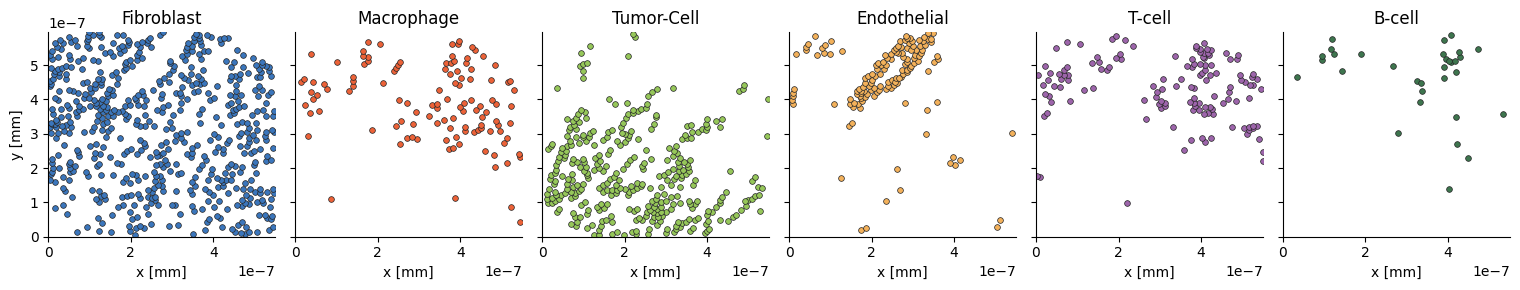

In [13]:
original_tissue.plot()

In [14]:
def effect_of_B_on_A(
    tissue: Tissue, 
    model: LightningCellMates, 
    cell_a: str, 
    cell_b: str, 
    n_samples: int = 100, 
    fraction: int = 0.1
):
    mean_cell_a_rates = []
    for _ in range(n_samples):
        if fraction < 1:
            modified_tissue = sub_sample_tissue(tissue, cell_b, fraction)
        elif fraction > 1:
            modified_tissue = over_sample_tissue(original_tissue, cell_b, fraction)
            
        mean_rate = mean_division_rate(modified_tissue, cell_a, model)
        mean_cell_a_rates.append(mean_rate)

    return np.array(mean_cell_a_rates)


In [15]:
from tdm.simulate.generate_distribution import correction_factor
from tdm.utils import log2_1p

In [16]:
w,h = original_tissue.tissue_dimensions()
n_F_per_nbrhood = original_tissue.n_cells('F') * correction_factor(w,h, 80*1e-6, mode='to_neighborhood')

log2_1p(n_F_per_nbrhood)



5.190977766599756

In [19]:
rates_05 = effect_of_B_on_A(
    tissue=original_tissue, 
    model=model, 
    cell_a = 'F', 
    cell_b='F',
    n_samples=30, 
    fraction=0.5
)

In [55]:
rates_2 = effect_of_B_on_A(
    tissue=original_tissue, 
    model=model, 
    cell_a = 'F', 
    cell_b='F',
    n_samples=30, 
    fraction=2.
)

In [22]:
original_rate = mean_division_rate(original_tissue, cell_a, model)

In [66]:
df = pd.concat([pd.DataFrame({
    'density': d,
    'rates' : rates
}) for (d,rates) in [('0.5x', rates_05), ('2x', rates_2)]])

In [67]:
df.loc[:,'rates'] = (df.loc[:,'rates']- original_rate) / original_rate

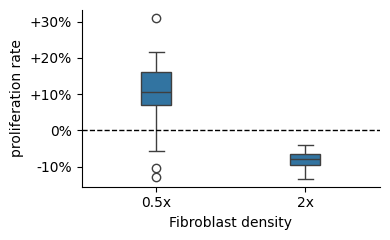

In [87]:
fig, ax = plt.subplots(figsize=(4,2.5))

sns.boxplot(df, x='density', y='rates', ax=ax, width=0.2)

ax.axhline(y=0, linestyle='--', linewidth=1, color='black')
sns.despine(ax=ax)

ax.set_xlabel('Fibroblast density')
ax.set_ylabel('proliferation rate')

float_to_percentage_axis(ax)
fig.tight_layout()

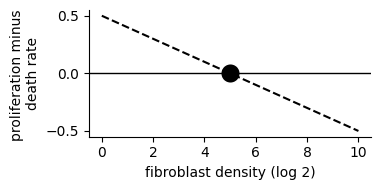

In [19]:
x = np.arange(0,11)
y = 0.1*(-x + 5)

fig, ax = plt.subplots(figsize=(4,2))

sns.lineplot(x=x,y=y, color='black', linestyle='--')
sns.scatterplot(x=[5], y=[0], color='black', s=200)

sns.despine(ax=ax)

ax.set_xlabel('fibroblast density (log 2)')
ax.set_ylabel('proliferation minus \ndeath rate')
ax.axhline(y=0, linestyle='-', color='black', linewidth='1')

fig.tight_layout()

# The effect of adding more cells decreases with distance

In [ ]:
BreastCancerTissueDataset(
    tissue=original_tissue, 
    effective_distance=MAX_EFFECTIVE_DISTANCE, 
    responder_cell_type=FIBROBLAST
)

In [28]:
ds.tissue.cell_df()
F_idxs = 

In [30]:
F_df = original_tissue.cell_df().reset_index().iloc[F_idxs]

In [54]:
n_cells = 4
cell_i = 3
cell_type = FIBROBLAST
distance = 30


def add_cells(cellmates_ds, original_tissue, cell_i, n_cells, distance):
    """
    Add n cells at distance d around cell i
    """
    
    # fetch all cells considered valid in the dataset:
    valid_idxs = cellmates_ds.valid_cell_idxs
    valid_cells_df = original_tissue.cell_df().reset_index(drop=True).iloc[valid_idxs].reset_index(drop=True)

    target_cell = valid_cells_df.iloc[cell_i]
    x,y = target_cell[['x','y']]

    thetas = np.random.uniform(low=0, high=2*np.pi, size=n_cells)
    xs = x + np.cos(thetas)*distance
    ys = y + np.sin(thetas)*distance

    new_cells_df = pd.DataFrame({
        'cell_type': cell_type,
        'x': xs,
        'y': ys,
        'division': 0
    })

    st = StubTissue(
        cell_types=original_tissue.cell_types(),
        cell_df = new_cells_df,
        tissue_dimensions = original_tissue.tissue_dimensions()
    )

    return original_tissue + st

In [79]:
def predict_one_cell(sample, model):
    dl = DataLoader([sample], batch_size=1, collate_fn=collate_fn, shuffle=False)

    # compute predictions:
    trainer = pl.Trainer(devices=[4])
    predictions = trainer.predict(model, dl)

    # hack, effectively verbose=False
    from IPython.display import clear_output
    clear_output()
    
    return predictions[0].numpy()

In [109]:
abs_relative_effects = {
    'cell_i': [],
    'distance': [],
    'n_cells': [],
    'effect': []
}


for cell_i in range(1):# range(len(ds)):

    cell_i_original_rate = predict_one_cell(ds[cell_i], model)

    for distance in np.arange(0,20,10): # np.arange(0,141,10):

        for n_cells in [4]: # ,8,16

            modified_tissue = add_cells(
                cellmates_ds=ds, 
                original_tissue=original_tissue,
                cell_i=cell_i,
                n_cells=n_cells,
                distance=microns(distance)
            )

            modified_ds = BreastCancerTissueDataset(
                tissue=modified_tissue, 
                effective_distance=MAX_EFFECTIVE_DISTANCE, 
                responder_cell_type='F'
            )

            cell_i_modified_rate = predict_one_cell(modified_ds[cell_i], model)

            effect = (cell_i_modified_rate - cell_i_original_rate) / cell_i_original_rate

            abs_relative_effects['cell_i'].append(cell_i) 
            abs_relative_effects['distance'].append(distance)
            abs_relative_effects['n_cells'].append(n_cells)
            abs_relative_effects['effect'].append(effect)

In [108]:
ds[99].distances[0]

tensor([  0, 132, 130, 127, 129, 139, 131, 115, 121, 132, 119, 111, 129, 119,
        105, 118, 106, 134, 135, 119, 106, 104, 102,  91, 128, 106,  86, 110,
         83, 109,  80,  77,  93,  91, 137, 124,  98,  92,  88,  80, 128,  79,
         65,  75, 135,  95,  62,  82,  69,  58,  79, 133,  63,  63, 117, 110,
         93, 137,  51,  87, 114,  68, 125, 104,  58,  76, 106, 134,  92,  47,
         52,  97, 118,  77, 133,  67,  48,  37,  37, 111,  51,  62,  90,  91,
        101, 102, 109,  90,  81,  35,  39,  50,  22, 129, 112,  57,  17, 117,
         56,  37,  40,  76,  49,  73,  28, 117, 124, 134,  20,  60, 116, 102,
         26, 132,  91,  10,   9, 136,  20,  74, 105,  86,  66,  60,  74,  81,
        128,  33, 110,  18,  93,  13, 119,  29,  10,  29, 134,  85,  75, 130,
         44,  41,  58, 113,  59,  21,  95, 126,  53,  21,  25,  21,  51, 113,
         41, 122,  94,  50,  33,  81,  83,  32,  45, 138,  57,  59,  96,  43,
         32, 119,  32, 107,  79,  71,  36,  62, 136, 119, 106, 1

In [107]:
modified_ds[99].distances[0]

tensor([  0, 132, 130, 127, 129, 139, 131, 115, 121, 132, 119, 111, 129, 119,
        105, 118, 106, 134, 135, 119, 106, 104, 102,  91, 128, 106,  86, 110,
         83, 109,  80,  77,  93,  91, 137, 124,  98,  92,  88,  80, 128,  79,
         65,  75, 135,  95,  62,  82,  69,  58,  79, 133,  63,  63, 117, 110,
         93, 137,  51,  87, 114,  68, 125, 104,  58,  76, 106, 134,  92,  47,
         52,  97, 118,  77, 133,  67,  48,  37,  37, 111,  51,  62,  90,  91,
        101, 102, 109,  90,  81,  35,  39,  50,  22, 129, 112,  57,  17, 117,
         56,  37,  40,  76,  49,  73,  28, 117, 124, 134,  20,  60, 116, 102,
         26, 132,  91,  10,   9, 136,  20,  74, 105,  86,  66,  60,  74,  81,
        128,  33, 110,  18,  93,  13, 119,  29,  10,  29, 134,  85,  75, 130,
         44,  41,  58, 113,  59,  21,  95, 126,  53,  21,  25,  21,  51, 113,
         41, 122,  94,  50,  33,  81,  83,  32,  45, 138,  57,  59,  96,  43,
         32, 119,  32, 107,  79,  71,  36,  62, 136, 119, 106, 1

In [98]:
cell_i_original_rate

array(0.00790473, dtype=float32)

In [90]:
distance_effects_df = pd.DataFrame(abs_relative_effects)

In [91]:
distance_effects_df

,cell_i,distance,n_cells,effect
0,0,0,4,0.128042
1,0,0,8,0.221007
2,0,0,16,0.353722
3,0,10,4,0.185055
4,0,10,8,0.228519
...,...,...,...,...
4495,99,130,8,0.004054
4496,99,130,16,0.051218
4497,99,140,4,-0.001748
4498,99,140,8,-0.004621


In [96]:
from tdm.style import set_style

set_style()

Text(0, 0.5, 'relative change in proliferation')

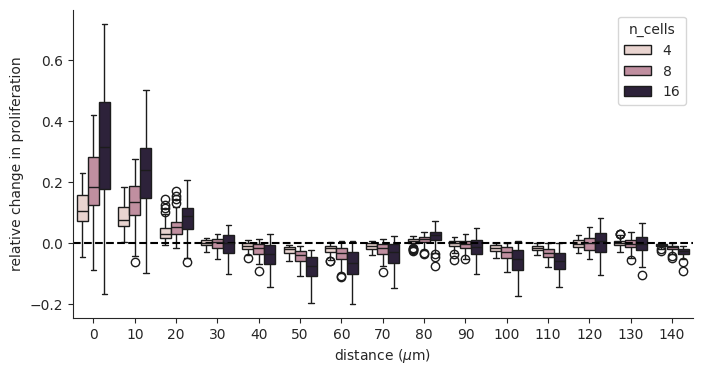

In [97]:
fig, ax = plt.subplots(figsize=(8,4))

sns.boxplot(distance_effects_df, x='distance', y='effect', hue='n_cells', ax=ax)

sns.despine(ax=ax)
ax.axhline(y=0, linestyle='--', color='black')

ax.set_xlabel('distance ($\mu$m)')
ax.set_ylabel('relative change in proliferation')

In [46]:

def compute_effects(n_samples: int = 10, remove_fraction: float = 0.5):
    effects = {}

    for cell_b in original_tissue.cell_types():

        e = effect_of_B_on_A(
            tissue=original_tissue,
            model=model,
            cell_a=FIBROBLAST,
            cell_b=cell_b,
            n_samples=n_samples,
            remove_fraction=remove_fraction
        )

        effects[cell_b] = e

    return effects

In [15]:

from tdm.cell_types import CELL_TYPE_TO_COLOR

In [16]:
def plot_effects(effects, original_rate, lim: float = 0.3):
    effects_df = pd.DataFrame(effects)
    effects_df = effects_df.melt(var_name='cell_type')
    # effects_df['value'] = np.log(effects_df['value'].astype(float) / original_rate)
    effects_df['value'] = (effects_df['value'].astype(float) - original_rate) / original_rate
    order = effects_df.groupby('cell_type').median().sort_values('value').index

    fig, ax = plt.subplots(figsize=(4,4))
    # colors = [[c] for c in order]
    sns.boxplot(effects_df, x='cell_type', y='value', hue='cell_type', legend=False, ax=ax, order=order, width=0.4, linewidth=1, linecolor='black', palette=CELL_TYPE_TO_COLOR)


    sns.despine(ax=ax)

    ax.axhline(0, linestyle='--', color='black', linewidth=1)
    ax.set_ylim(-lim, lim)

    ax.set_ylabel('relative change in proliferation rate')
    ax.set_xlabel('cell type')
    # ax.set_title('Change in fibroblast proliferation rate after removing \n50% of cells of each type')

    def to_percentage(x, pos):
        sign_str = '+' if x>0 else ''
        return f'{sign_str}{100 * x :.0f}%'

    # Setting the formatter for the y-axis
    ax.yaxis.set_major_formatter(FuncFormatter(to_percentage))

    fig.tight_layout()

In [106]:
effects_2x = compute_effects(n_samples=30, remove_fraction = 1/2)
effects_4x = compute_effects(n_samples=30, remove_fraction = 3/4)
effects_8x = compute_effects(n_samples=30, remove_fraction = 7/8)

Trainer will use only 1 of 6 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=6)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]
/home/jsomer/cellmates/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

/home/jsomer/cellmates/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


TypeError: hstack(): argument 'tensors' (position 1) must be tuple of Tensors, not NoneType

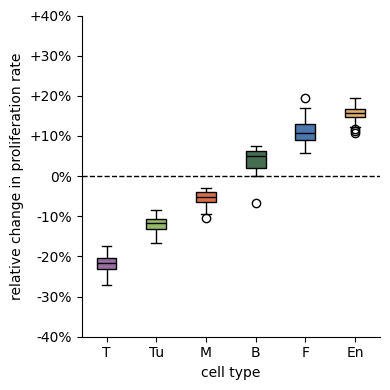

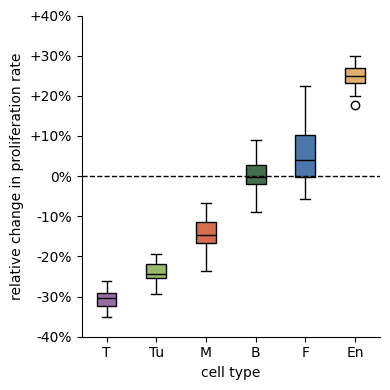

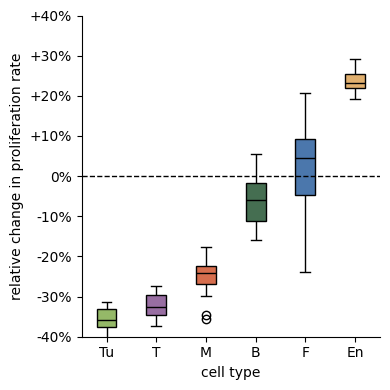

In [94]:
plot_effects(effects_2x, original_rate, lim=0.4)
plot_effects(effects_4x, original_rate, lim=0.4)
plot_effects(effects_8x, original_rate, lim=0.4)

# Plot difference in proliferation spatially

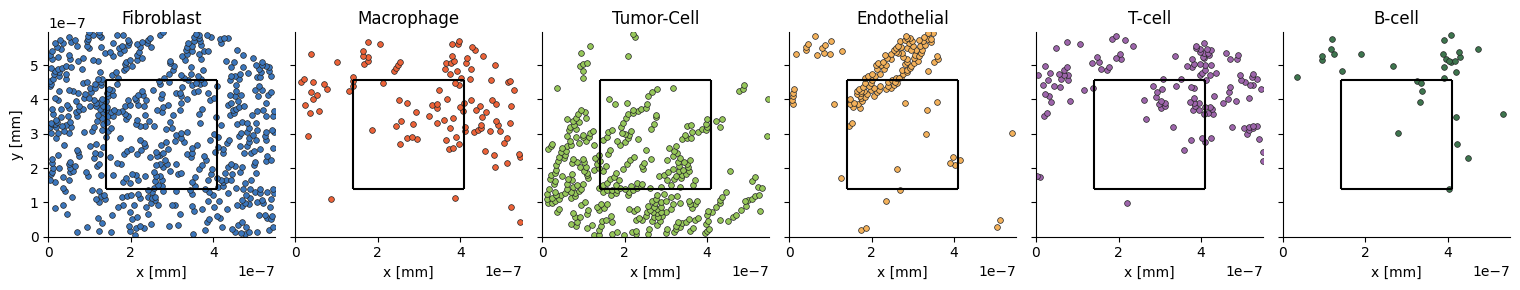

In [21]:
original_tissue.plot(all_on_one_plot=False, cell_subset=['F', 'M', 'T', 'Tu', 'En', 'B'], plot_effective_capture_area=True, neighborhood_size=140*1e-6)

In [22]:
rates = predict_all_cells(
    tissue=original_tissue,
    model=model,
    cell_type=FIBROBLAST
)

In [91]:
from tdm.tissue import Tissue

In [58]:
# no_endothel_tissue = sub_sample_tissue(original_tissue, 'En', 1.)

# no_endothel_rates = predict_all_cells(
#     tissue=no_endothel_tissue,
#     model=model,
#     cell_type=FIBROBLAST
# )

sub_rates = []
for i in range(50):
    sub_tissue = sub_sample_tissue(original_tissue, cell_b='Tu', remove_fraction=3/4, lt_y=140*1e-6)

    no_endothel_rates = predict_all_cells(
        tissue=sub_tissue,
        model=model,
        cell_type=FIBROBLAST
    )

    sub_rates.append(no_endothel_rates)

no_endothel_rates = torch.stack(sub_rates).mean(axis=0)

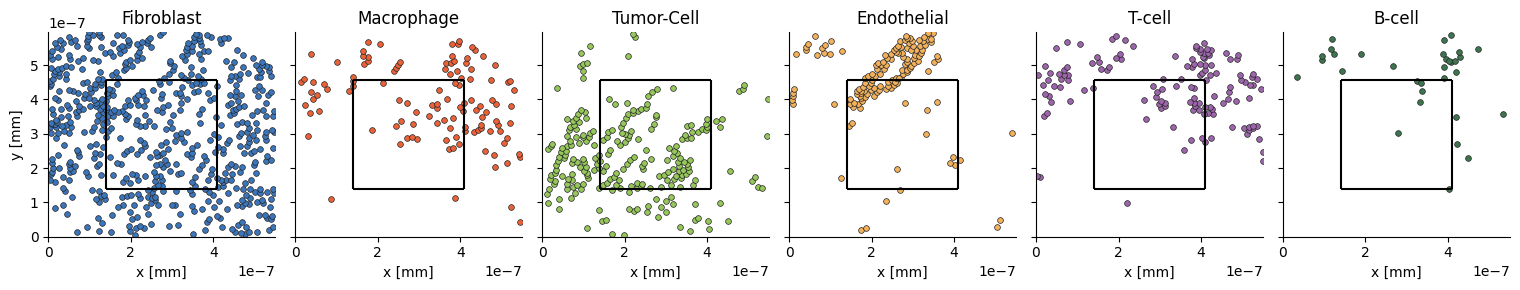

In [60]:
sub_tissue.plot(all_on_one_plot=False, cell_subset=['F', 'M', 'T', 'Tu', 'En', 'B'], plot_effective_capture_area=True, neighborhood_size=140*1e-6)

In [43]:
df = original_tissue.cell_df()

Text(0, 0.5, 'y [mm]')

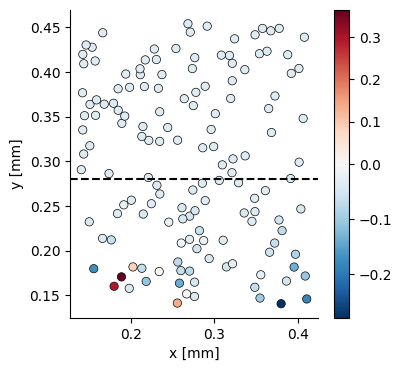

In [62]:
fig, ax = plt.subplots(figsize=(4,4))

cells = df.iloc[ds.valid_cell_idxs]
cells.loc[:,'x'] = cells['x'] / 1e-3
cells.loc[:,'y'] = cells['y'] / 1e-3


rate_diff = (no_endothel_rates-rates)/rates
sns.scatterplot(cells, x='x', y='y', hue=rate_diff, ax=ax, palette='RdBu_r', edgecolor='black')

norm = mcolors.TwoSlopeNorm(vmin=rate_diff.min(), vmax=rate_diff.max(), vcenter=0)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm, ax=ax)

# max effective range:
ax.axhline(y=0.28, linestyle='--', color='black')
# ax.axvline(x=0.28, linestyle='--', color='black')
sns.despine(ax=ax)
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')

# Communication logic - antagonistic, additive or agonistic

In [40]:
def interaction(gab, ga,gb):
     return np.log2(gab-(ga*gb) + 1)

In [21]:
def proliferation_rate(
    original_tissue: Tissue, 
    model: LightningCellMates, 
    responder_cell: str,
    cell_a: str, 
    cell_b: str | None = None, 
    n_samples: int = 100, 
    remove_fraction_a: float = 0.,
    remove_fraction_b: float = 0.,
):

    rates = []
    for _ in range(n_samples):
        
        sub_sampled_tissue = sub_sample_tissue(original_tissue, cell_a, remove_fraction_a)

        if cell_b is not None:
            sub_sampled_tissue = sub_sample_tissue(sub_sampled_tissue, cell_b, remove_fraction_b)

        # compute mean proliferation rate for all responder cells in the tissue 
        mean_rate = mean_division_rate(sub_sampled_tissue, responder_cell, model)
        rates.append(mean_rate)

    return np.mean(rates)

In [26]:
fraction_of_original_cells = np.arange(0,1.1,0.2)
fraction_of_original_cells

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [41]:
cell_a = 'T'
cell_b = 'Tu'

ga = {}
gb = {}

for f in fraction_of_original_cells:

    ga[f] = proliferation_rate(
        original_tissue,
        model=model,
        responder_cell = FIBROBLAST,
        cell_a = cell_a,
        n_samples = 5,
        remove_fraction_a = 1-f,
    ) / original_rate

    gb[f] = proliferation_rate(
        original_tissue,
        model=model,
        responder_cell = FIBROBLAST,
        cell_a = cell_b,
        n_samples = 5,
        remove_fraction_a = 1-f,
    ) / original_rate


In [42]:
a_fracs = fraction_of_original_cells
b_fracs = fraction_of_original_cells
a_fracs_mesh, b_fracs_mesh = np.meshgrid(a_fracs, b_fracs)

gab_vals = []
interactions = []
for frac_a, frac_b in zip(a_fracs_mesh.ravel(), b_fracs_mesh.ravel()):
    
    gab = proliferation_rate(
            original_tissue,
            model=model,
            responder_cell = FIBROBLAST,
            cell_a = cell_a,
            cell_b = cell_b,
            n_samples = 5,
            remove_fraction_a = 1-frac_a,
            remove_fraction_b = 1-frac_b,
    ) / original_rate
    
    gab_vals.append(gab)
    interactions.append(interaction(gab, ga[frac_a], gb[frac_b]))

gab_vals = np.array(gab_vals).reshape(a_fracs_mesh.shape)
interactions = np.array(interactions).reshape(a_fracs_mesh.shape)

In [43]:
gab_vals

array([[0.23759438, 0.2651507 , 0.3079332 , 0.33791113, 0.37399265,
        0.40223646],
       [0.39884955, 0.493769  , 0.51426566, 0.5830481 , 0.66146636,
        0.7275633 ],
       [0.5329299 , 0.5468387 , 0.6514312 , 0.7011934 , 0.7636186 ,
        0.8275527 ],
       [0.62817246, 0.60886353, 0.6875717 , 0.7523717 , 0.8346934 ,
        0.9217931 ],
       [0.69909155, 0.6563352 , 0.7349278 , 0.821651  , 0.8697328 ,
        0.9694994 ],
       [0.7536353 , 0.68161017, 0.7403035 , 0.84606105, 0.9240245 ,
        1.        ]], dtype=float32)

In [44]:
interactions

array([[-0.09780324, -0.01245675, -0.00318149,  0.01206439,  0.00296812,
         0.        ],
       [-0.19174083,  0.03027403, -0.03078582,  0.02036825,  0.027733  ,
         0.04711168],
       [-0.14940166, -0.03394902,  0.00799221,  0.02142608, -0.0158899 ,
        -0.0146858 ],
       [-0.10015365, -0.02762586, -0.03462303, -0.0048485 , -0.02667662,
        -0.00103992],
       [-0.04907511, -0.00748627, -0.02109398,  0.03616187, -0.04252001,
        -0.00361651],
       [ 0.        ,  0.00150767, -0.04502294,  0.03823548, -0.00092152,
         0.        ]])

In [45]:
a_fracs_mesh

array([[0. , 0.2, 0.4, 0.6, 0.8, 1. ],
       [0. , 0.2, 0.4, 0.6, 0.8, 1. ],
       [0. , 0.2, 0.4, 0.6, 0.8, 1. ],
       [0. , 0.2, 0.4, 0.6, 0.8, 1. ],
       [0. , 0.2, 0.4, 0.6, 0.8, 1. ],
       [0. , 0.2, 0.4, 0.6, 0.8, 1. ]])

-0.19174083091416608

<Axes: >

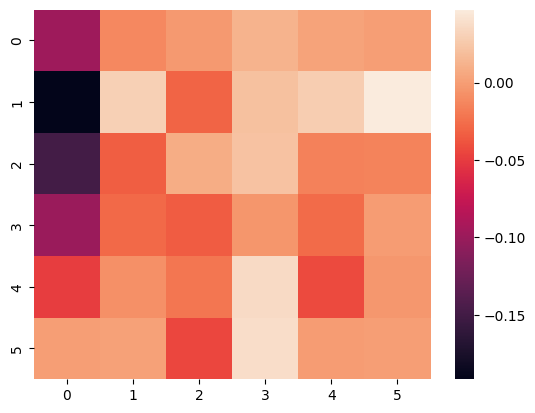

In [78]:
sns.heatmap(interactions)

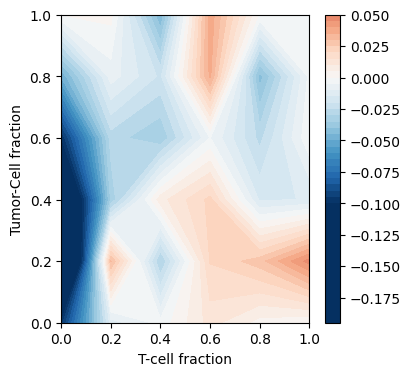

In [77]:
# vmax = max(abs(interactions.max()), abs(interactions.min()))
vmax = 0.1

norm = mcolors.TwoSlopeNorm(vcenter=0, vmax=vmax, vmin=-vmax)
fig = plt.contourf(
    a_fracs_mesh, 
    b_fracs_mesh, 
    interactions, 
    cmap='RdBu_r', 
    levels=50, 
    norm=norm
)

fig.figure.set_size_inches(4, 4)
plt.colorbar(fig)

ax = fig.figure.axes[0]

ax.set_xlabel(f'{CELL_TYPE_TO_FULL_NAME[cell_a]} fraction')
ax.set_ylabel(f'{CELL_TYPE_TO_FULL_NAME[cell_b]} fraction')

plt.show()


In [72]:
np.log2(0.7 - 0.7*0.7 + 1)

0.27500704749986976

<Axes: >

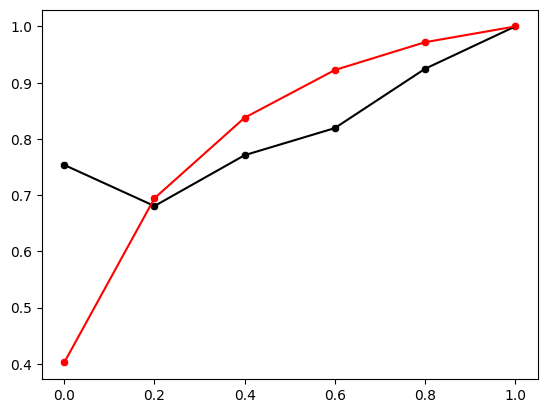

In [75]:
sns.lineplot(y=ga.values(), x=fraction_of_original_cells, color='black')
sns.scatterplot(y=ga.values(), x=fraction_of_original_cells, color='black')

sns.lineplot(y=gb.values(), x=fraction_of_original_cells, color='red')
sns.scatterplot(y=gb.values(), x=fraction_of_original_cells, color='red')

In [2]:
import torch 



6